# Telecom Churn Case Study- Problem Statement
- In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
- For many incumbent operators, retaining high profitable customers is the number one business goal.
- To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.
In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Importing Telecom Data

In [2]:
telecom_df = pd.read_csv('telecom_churn_data.csv')

In [3]:
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
# Looking for %age of null Values
round(100*(telecom_df.isnull().sum()/len(telecom_df.index)), 2)

mobile_number     0.00
circle_id         0.00
loc_og_t2o_mou    1.02
std_og_t2o_mou    1.02
loc_ic_t2o_mou    1.02
                  ... 
aon               0.00
aug_vbc_3g        0.00
jul_vbc_3g        0.00
jun_vbc_3g        0.00
sep_vbc_3g        0.00
Length: 226, dtype: float64

## Data Preparation

In [5]:
# create Churn data

telecom_df1 = telecom_df
telecom_df1['total_rech_amt_good_phase'] = (telecom_df1['total_rech_amt_6'] + telecom_df1['total_rech_amt_7'])/2
telecom_df1 = telecom_df1[telecom_df1['total_rech_amt_good_phase'] > telecom_df1['total_rech_amt_good_phase'].quantile(0.70)]

telecom_df1['total_usage_col'] = telecom_df1['total_og_mou_9'] + telecom_df1['total_ic_mou_9'] + telecom_df1['vol_2g_mb_9'] + telecom_df1['vol_3g_mb_9']

telecom_df1['churn'] = np.where(telecom_df1['total_usage_col']== 0, 1, 0)
telecom_df1['churn'].value_counts()

<ipython-input-5-dbffb6f1fc26>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_df1['total_usage_col'] = telecom_df1['total_og_mou_9'] + telecom_df1['total_ic_mou_9'] + telecom_df1['vol_2g_mb_9'] + telecom_df1['vol_3g_mb_9']
<ipython-input-5-dbffb6f1fc26>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_df1['churn'] = np.where(telecom_df1['total_usage_col']== 0, 1, 0)


0    27390
1     2589
Name: churn, dtype: int64

#### Filter high-value customers
- Scoping our sample to the High valued customer (top 30%) who demonstrated high spending in the initial two months.
- Churn Indicator created based on the provided business logics

In [6]:
telecom_df1 = telecom_df1.drop(['total_rech_amt_good_phase','total_usage_col'],1)

##### Tag churners and remove attributes of the churn phase
- For scope of analysis dropping all the variables of the 9th month after the churn indicator creation

In [7]:
nine_col = [col for col in telecom_df1.columns if '_9' in col]
print(telecom_df1.shape)
telecom_df1 = telecom_df1.drop(nine_col, axis = 1)
print(telecom_df1.shape)
telecom_df1 = telecom_df1.drop('sep_vbc_3g', axis=1)

(29979, 227)
(29979, 173)


### Churn rate-

In [8]:
y = telecom_df1['churn']
churn = (sum(y)/len(y.index))*100
print(churn)
print(telecom_df1.shape)

8.636045231662164
(29979, 172)


###### Churn rate is 8.63.


In [9]:
telecom_df1.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn
count,2.997900e+04,29979.0,29865.0,29865.0,29865.0,29979.000000,29979.000000,29979.000000,29663.000000,29676.000000,...,29979.000000,29979.000000,11387.000000,11652.000000,11741.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000
mean,7.001223e+09,109.0,0.0,0.0,0.0,587.587624,589.424681,535.067748,299.392147,307.701888,...,0.150339,0.140498,0.897603,0.889804,0.837322,1264.158911,129.482436,135.225368,121.450911,0.08636
std,6.846594e+05,0.0,0.0,0.0,0.0,442.848876,463.049067,492.447887,462.369385,483.432401,...,0.969779,0.975212,0.303184,0.313147,0.369087,975.181038,390.625027,408.218570,389.910814,0.28090
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000
25%,7.000641e+09,109.0,0.0,0.0,0.0,364.352500,365.235000,289.782000,43.030000,42.775000,...,0.000000,0.000000,1.000000,1.000000,1.000000,480.000000,0.000000,0.000000,0.000000,0.00000
50%,7.001232e+09,109.0,0.0,0.0,0.0,495.951000,493.781000,452.232000,128.480000,128.120000,...,0.000000,0.000000,1.000000,1.000000,1.000000,914.000000,0.000000,0.000000,0.000000,0.00000
75%,7.001814e+09,109.0,0.0,0.0,0.0,704.184500,700.986000,671.349500,357.655000,365.127500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1923.500000,1.600000,2.025000,0.000000,0.00000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,35.000000,41.000000,1.000000,1.000000,1.000000,4321.000000,12916.220000,9165.600000,11166.210000,1.00000


In [10]:
round(100*(telecom_df1.isnull().sum()/len(telecom_df1.index)), 2)

mobile_number     0.00
circle_id         0.00
loc_og_t2o_mou    0.38
std_og_t2o_mou    0.38
loc_ic_t2o_mou    0.38
                  ... 
aon               0.00
aug_vbc_3g        0.00
jul_vbc_3g        0.00
jun_vbc_3g        0.00
churn             0.00
Length: 172, dtype: float64

#### Dropping colums with one unique value (showing zero variance)

In [11]:
#delete coloumn as all value are zero or constant
telecom_df2 = telecom_df1.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6',
                     'std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7',
                   'std_ic_t2o_mou_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8'], 1)

In [12]:
#Droping column
fields_to_be_imputed_with_2 = ['fb_user','night_pck_user','arpu_2g','arpu_3g','av_rech_amt_data','count_rech_3g',
'count_rech_2g','max_rech_data','total_rech_data','date_of_last_rech_data']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2 = telecom_df2.drop([field_to_be_imputed_with_2], 1)
        
print(telecom_df2.shape)

(29979, 129)


In [13]:
fields_to_be_imputed_with_2 = ['date_of_last_rech']

for field in fields_to_be_imputed_with_2:
    for month in ['6', '7', '8']:
        field_to_be_imputed_with_2 = field + '_' + month
        telecom_df2[field_to_be_imputed_with_2].fillna(telecom_df2[field_to_be_imputed_with_2].mode()[0], inplace=True)

In [14]:
telecom_df2['date_of_last_rech_6'] = pd.to_datetime(telecom_df2.date_of_last_rech_6).dt.day
telecom_df2['date_of_last_rech_7'] = pd.to_datetime(telecom_df2.date_of_last_rech_7).dt.day
telecom_df2['date_of_last_rech_8'] = pd.to_datetime(telecom_df2.date_of_last_rech_8).dt.day

#### Imputing missing observations with Median column value

In [15]:
missing_cols = telecom_df2.columns[telecom_df2.isnull().sum()>0]
for col in missing_cols:
    telecom_df2[col].fillna((telecom_df2[col].median()), inplace=True)

In [16]:
round(100*(telecom_df2.isnull().sum()/len(telecom_df2.index)), 2)

mobile_number    0.0
arpu_6           0.0
arpu_7           0.0
arpu_8           0.0
onnet_mou_6      0.0
                ... 
aon              0.0
aug_vbc_3g       0.0
jul_vbc_3g       0.0
jun_vbc_3g       0.0
churn            0.0
Length: 129, dtype: float64

In [17]:
telecom_df3 = telecom_df2
telecom_df3.shape

(29979, 129)

#### Creating derived colums
- Average values of 3 months for each attributes were created to check if that value could address all the months.
- Median value of Internet usage (2G + 3G) across months was created to capture the churn rate as it was observed majority of the churn happens when the internet usage pattern shows a decline
- The AON variable was used to create tenure buckets. It was observed larger the tenure, lesser was the churn - as customers who are newly acquired to the network churned more as compared to the old customers.

In [18]:
# month_cols =  ['arpu','onnet_mou','offnet_mou','roam_ic_mou','roam_og_mou','loc_og_t2t_mou','loc_og_t2m_mou','loc_og_t2f_mou',
# 'loc_og_t2c_mou','loc_og_mou','std_og_t2t_mou','std_og_t2m_mou','std_og_t2f_mou','std_og_mou','isd_og_mou',
# 'spl_og_mou','og_others','total_og_mou','loc_ic_t2t_mou','loc_ic_t2m_mou','loc_ic_t2f_mou','loc_ic_mou',
# 'std_ic_t2t_mou','std_ic_t2m_mou','std_ic_t2f_mou','std_ic_mou','total_ic_mou','spl_ic_mou','isd_ic_mou',
# 'ic_others','total_rech_num','total_rech_amt','max_rech_amt','last_day_rch_amt','vol_2g_mb','vol_3g_mb',
# 'monthly_2g','sachet_2g','monthly_3g','sachet_3g']

# month_val = ['6','7','8']
# s = []


# for col in month_cols:

#     col_var_list = [col + "_" + x for x in month_val]
#     avg_val_col = col + "_avg"    
#     s.append(avg_val_col)
#     telecom_df3[avg_val_col] = telecom_df3[col_var_list].mean(axis=1)


# telecom_df3.reset_index(drop=True, inplace=True)

telecom_df3['int_usage_median'] = telecom_df3[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']].median(axis=1)
telecom_df3['int_usage_median'] = telecom_df3.int_usage_median.map(lambda x: 1 if x == 0 else 0)
telecom_df3 = telecom_df3.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'], 1)


telecom_df3['tenure_buck'] = np.round(telecom_df3['aon']/365,1)
bins = [0, 1, 2, 3, 4, 10]
telecom_df3['tenure_buck'] = pd.cut(telecom_df3['tenure_buck'], bins)
telecom_df3['tenure_buck'].value_counts()

(4, 10]    9610
(1, 2]     7486
(0, 1]     5320
(2, 3]     4530
(3, 4]     2962
Name: tenure_buck, dtype: int64

## Outlier Treatment

In [19]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,int_usage_median
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,...,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000,29979.000000
mean,7.001223e+09,587.587624,589.424681,535.067748,297.590611,305.886840,271.137938,421.142281,426.990330,383.029940,...,0.173321,0.138063,0.150339,0.140498,1264.158911,129.482436,135.225368,121.450911,0.08636,0.690950
std,6.846594e+05,442.848876,463.049067,492.447887,460.257092,481.318377,465.205131,468.998414,485.030117,473.464516,...,0.583178,0.875984,0.969779,0.975212,975.181038,390.625027,408.218570,389.910814,0.28090,0.462109
min,7.000000e+09,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1%,7.000028e+09,18.221200,25.600600,0.000000,0.000000,0.000000,0.000000,1.057800,1.099000,0.000000,...,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.00000,0.000000
10%,7.000269e+09,270.692200,274.458200,134.118600,12.230000,11.726000,6.906000,58.606000,59.604000,35.072000,...,0.000000,0.000000,0.000000,0.000000,294.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,7.000641e+09,364.352500,365.235000,289.782000,43.590000,43.370000,34.060000,142.860000,141.280000,111.780000,...,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,7.001232e+09,495.951000,493.781000,452.232000,128.480000,128.120000,106.390000,285.990000,285.630000,251.530000,...,0.000000,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,7.001814e+09,704.184500,700.986000,671.349500,353.500000,360.360000,298.215000,523.625000,532.905000,483.000000,...,0.000000,0.000000,0.000000,0.000000,1923.500000,1.600000,2.025000,0.000000,0.00000,1.000000
90%,7.002167e+09,994.311800,996.051400,985.499200,795.354000,825.486000,724.182000,916.490000,935.716000,854.006000,...,1.000000,0.000000,0.000000,0.000000,2846.000000,439.100000,455.078000,395.168000,0.00000,1.000000


In [20]:
telecom_df3.describe(percentiles=[0.01, 0.10,.25,.5,.75,.90,.95,.99])

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,int_usage_median
count,2.997900e+04,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,...,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.00000,29979.000000
mean,7.001223e+09,587.587624,589.424681,535.067748,297.590611,305.886840,271.137938,421.142281,426.990330,383.029940,...,0.173321,0.138063,0.150339,0.140498,1264.158911,129.482436,135.225368,121.450911,0.08636,0.690950
std,6.846594e+05,442.848876,463.049067,492.447887,460.257092,481.318377,465.205131,468.998414,485.030117,473.464516,...,0.583178,0.875984,0.969779,0.975212,975.181038,390.625027,408.218570,389.910814,0.28090,0.462109
min,7.000000e+09,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1%,7.000028e+09,18.221200,25.600600,0.000000,0.000000,0.000000,0.000000,1.057800,1.099000,0.000000,...,0.000000,0.000000,0.000000,0.000000,189.000000,0.000000,0.000000,0.000000,0.00000,0.000000
10%,7.000269e+09,270.692200,274.458200,134.118600,12.230000,11.726000,6.906000,58.606000,59.604000,35.072000,...,0.000000,0.000000,0.000000,0.000000,294.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,7.000641e+09,364.352500,365.235000,289.782000,43.590000,43.370000,34.060000,142.860000,141.280000,111.780000,...,0.000000,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,7.001232e+09,495.951000,493.781000,452.232000,128.480000,128.120000,106.390000,285.990000,285.630000,251.530000,...,0.000000,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,7.001814e+09,704.184500,700.986000,671.349500,353.500000,360.360000,298.215000,523.625000,532.905000,483.000000,...,0.000000,0.000000,0.000000,0.000000,1923.500000,1.600000,2.025000,0.000000,0.00000,1.000000
90%,7.002167e+09,994.311800,996.051400,985.499200,795.354000,825.486000,724.182000,916.490000,935.716000,854.006000,...,1.000000,0.000000,0.000000,0.000000,2846.000000,439.100000,455.078000,395.168000,0.00000,1.000000


### Correlation Analysis

In [21]:
# Create correlation matrix
corr_matrix = telecom_df3.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
to_drop

telecom_df3 = telecom_df3.drop(to_drop, 1)

In [22]:
#create dummy for tenure_buck 
telecom_df3 = pd.get_dummies(telecom_df3, drop_first=True)

In [23]:
telecom_df3.rename(columns={"tenure_buck_(1, 2]": "tenure_buck_1_to_2","tenure_buck_(2, 3]":"tenure_buck_2_to_3",
                   "tenure_buck_(3, 4]":"tenure_buck_3_to_4",
                   "tenure_buck_(4, 10]":"tenure_buck_4_to_10"}, inplace=True)

In [24]:
telecom_df3.shape

(29979, 70)

In [25]:
# After outlier treatment droping column which don't have much variance or zero variance
telecom_df4 = telecom_df3.drop(['og_others_7','og_others_8','spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','aon'], 1)

In [26]:
telecom_df4.shape

(29979, 64)

## Exploratory data analysis

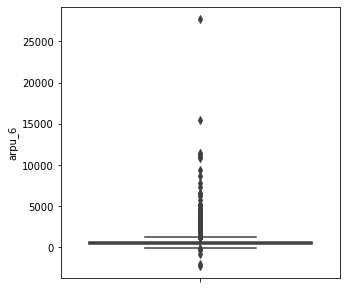

In [27]:
from scipy.stats import norm
plt.figure(figsize=(5, 5))
sns.boxplot(y='arpu_6', data=telecom_df3)

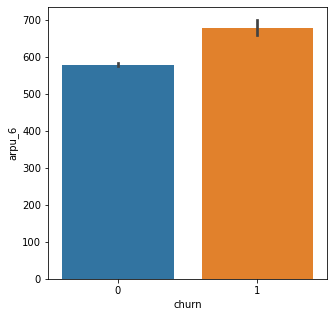

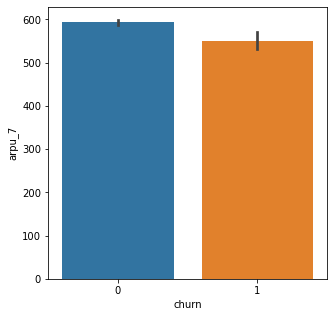

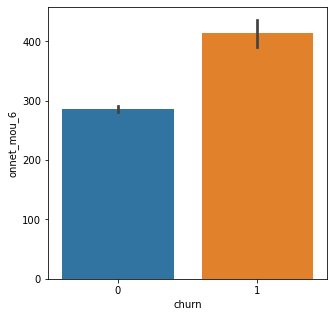

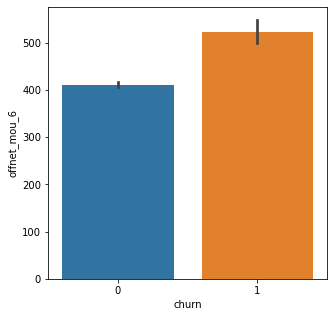

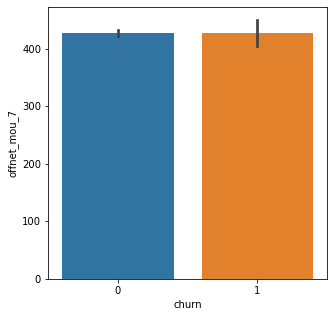

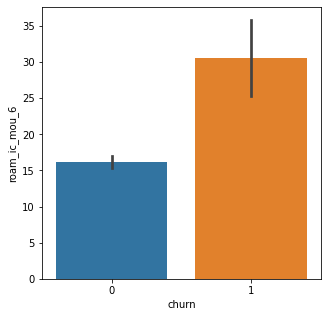

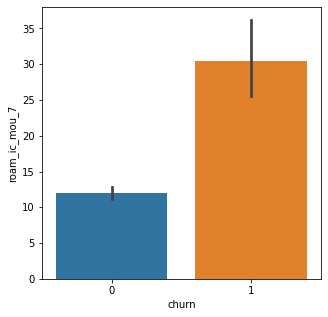

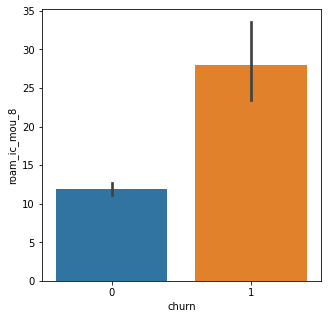

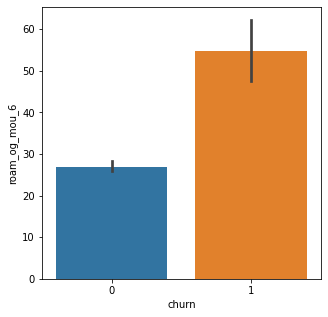

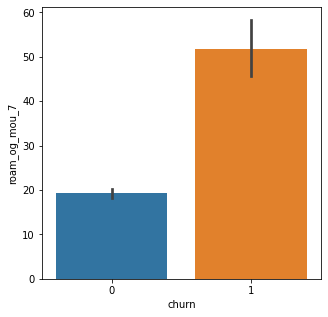

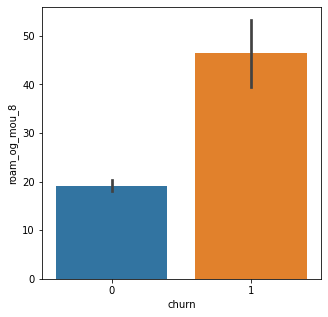

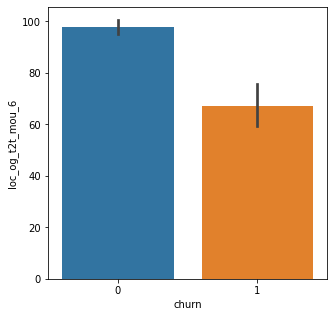

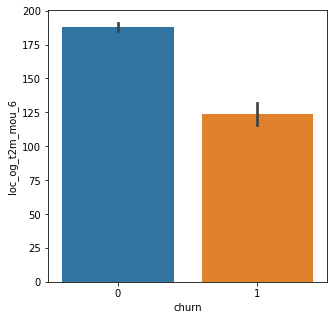

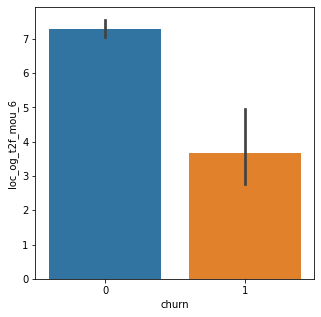

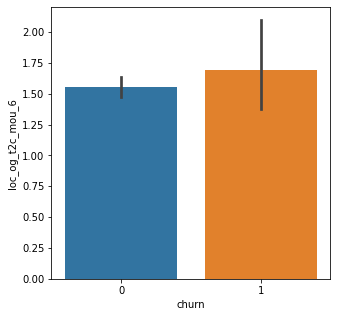

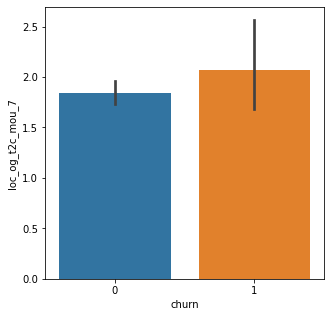

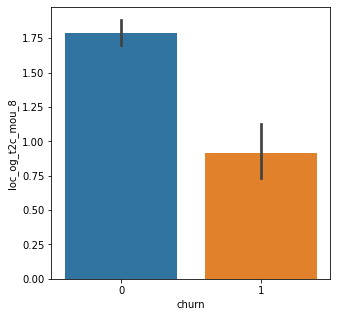

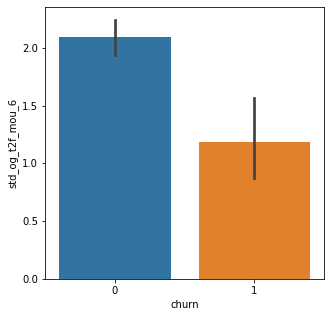

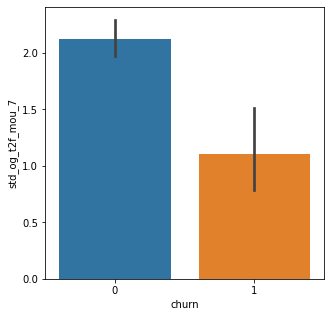

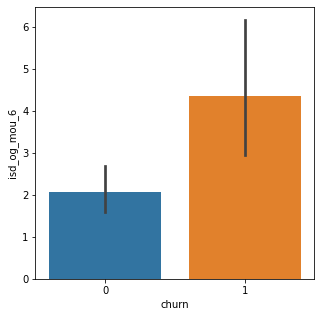

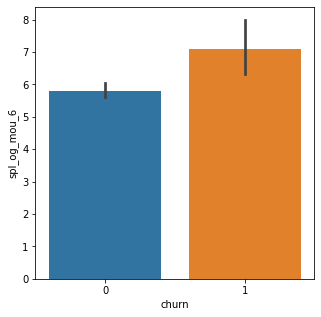

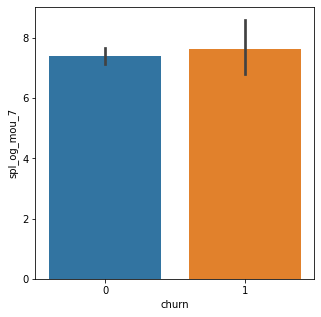

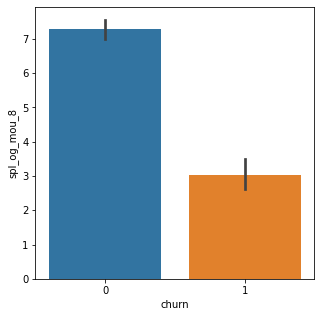

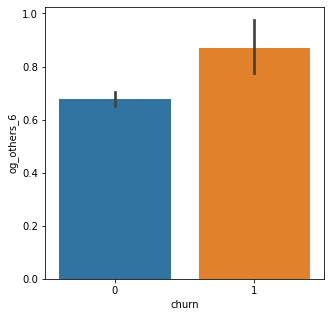

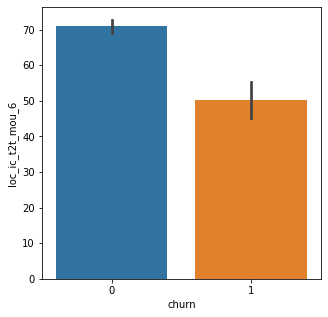

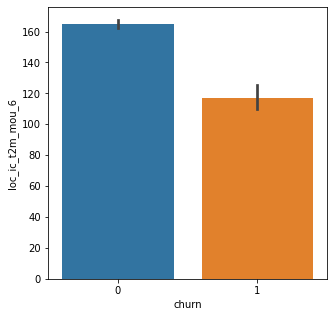

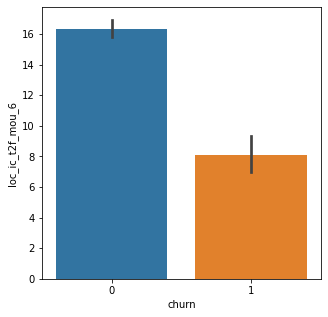

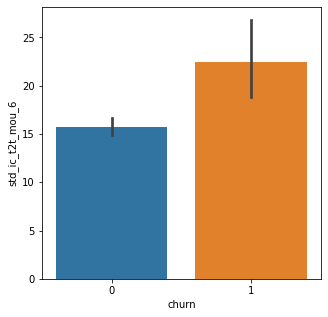

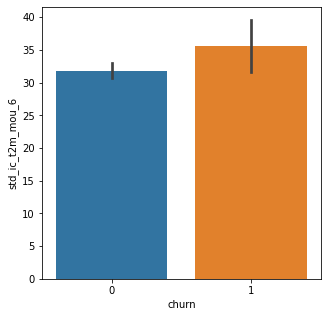

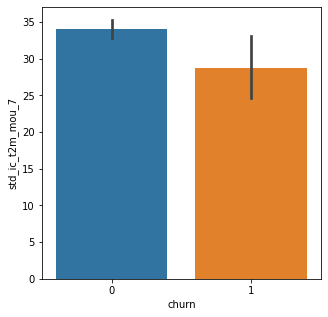

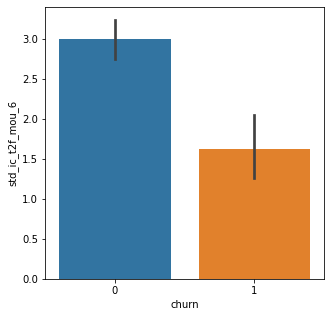

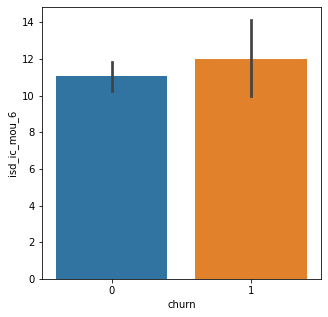

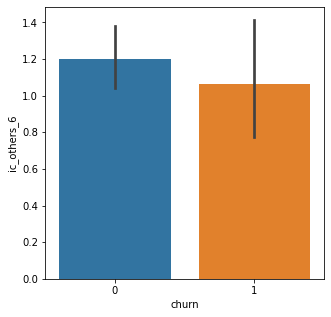

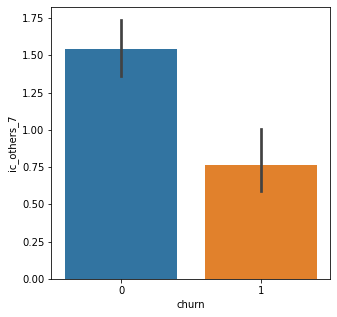

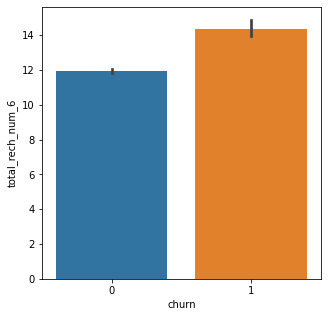

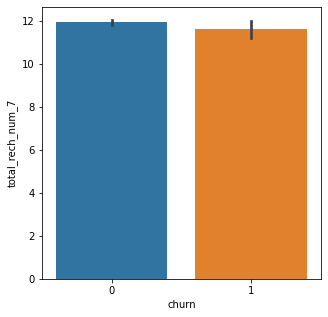

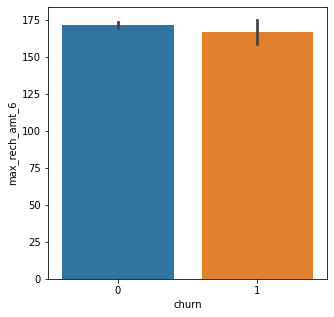

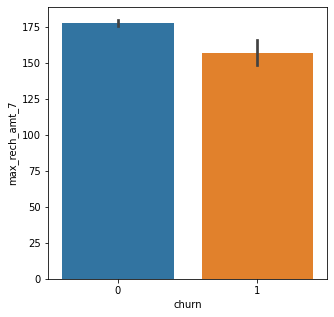

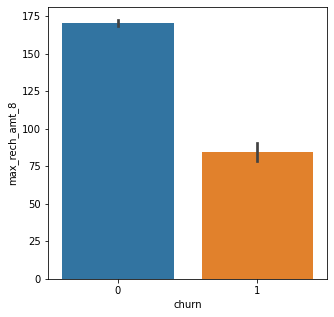

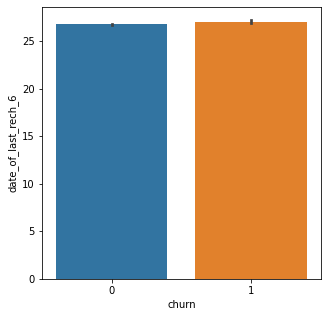

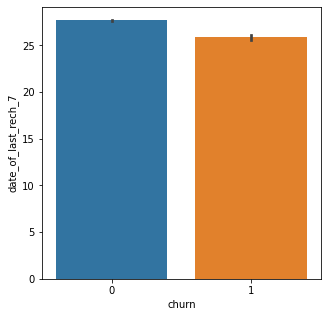

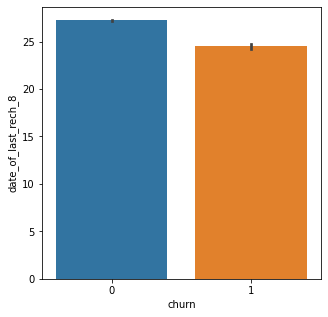

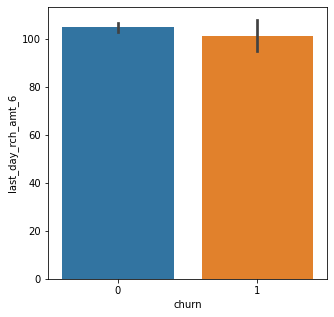

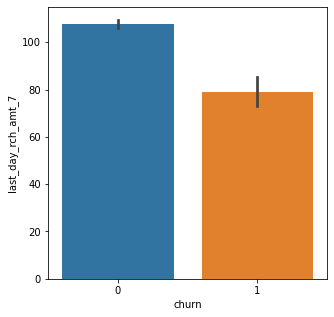

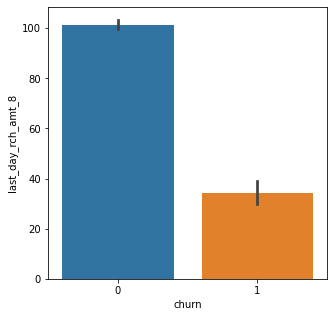

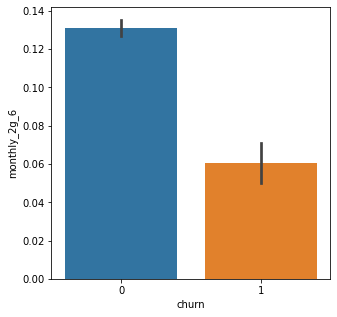

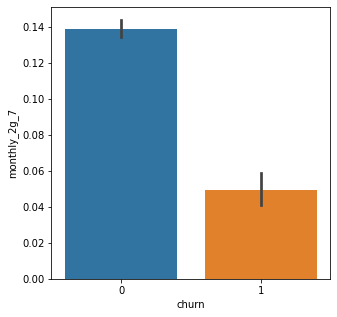

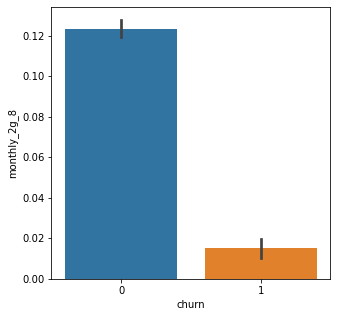

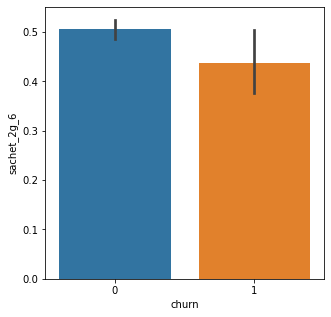

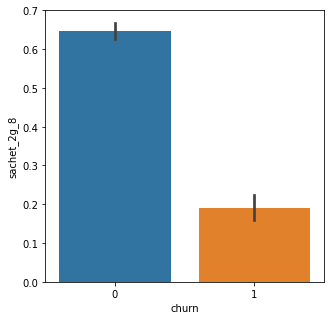

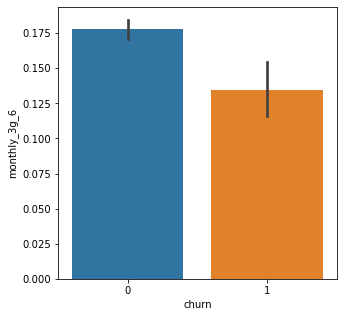

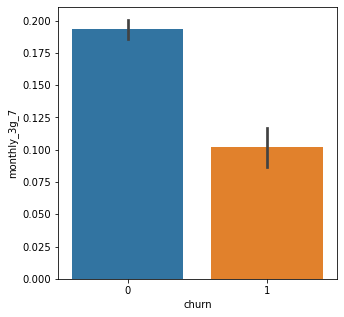

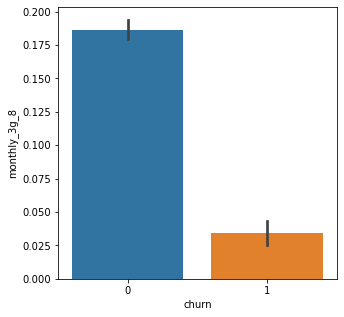

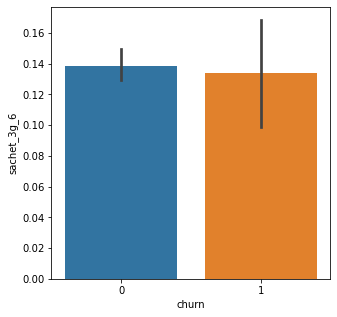

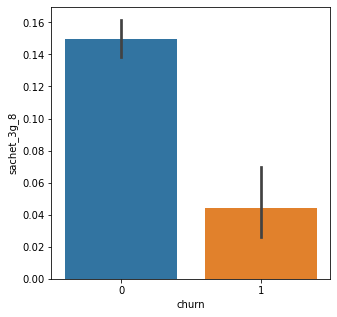

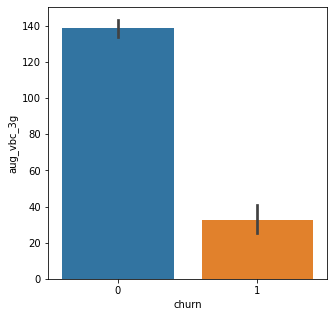

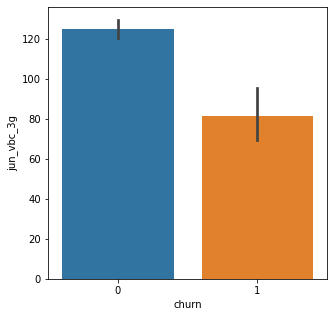

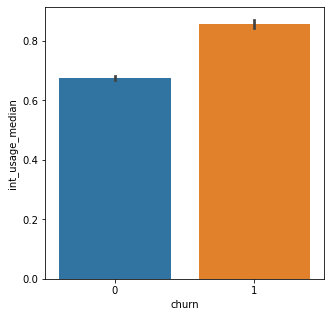

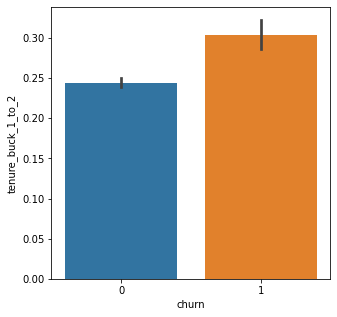

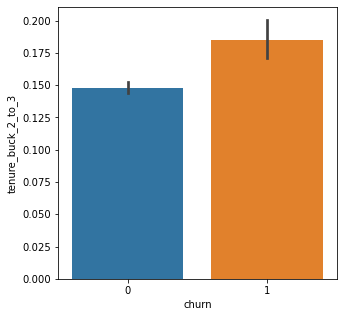

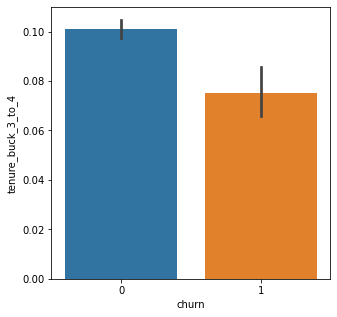

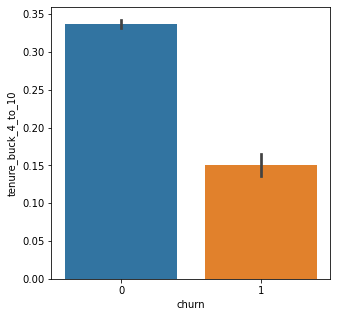

In [28]:
cont_cols = [col for col in telecom_df4.columns if col not in ['churn','mobile_number']]
for col in cont_cols:
    plt.figure(figsize=(5, 5))
    sns.barplot(x='churn', y=col, data=telecom_df4)
    plt.show()



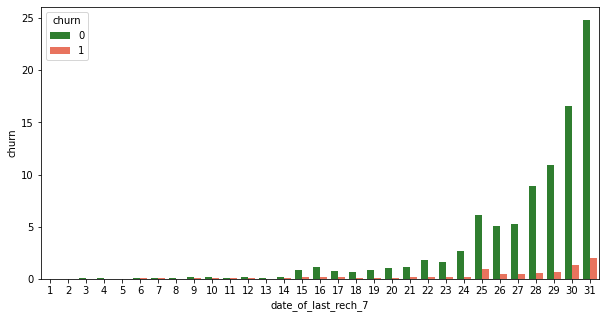

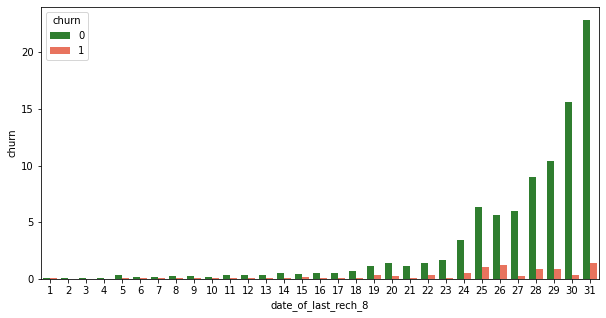

In [29]:
plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_7", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

plt.figure(figsize=(10,5))
palette = ["#228B22", "#FF6347"]
sns.barplot(x="date_of_last_rech_8", y="churn", hue="churn", data=telecom_df4, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df4) * 100)

In [30]:
telecom_df4.shape

(29979, 64)

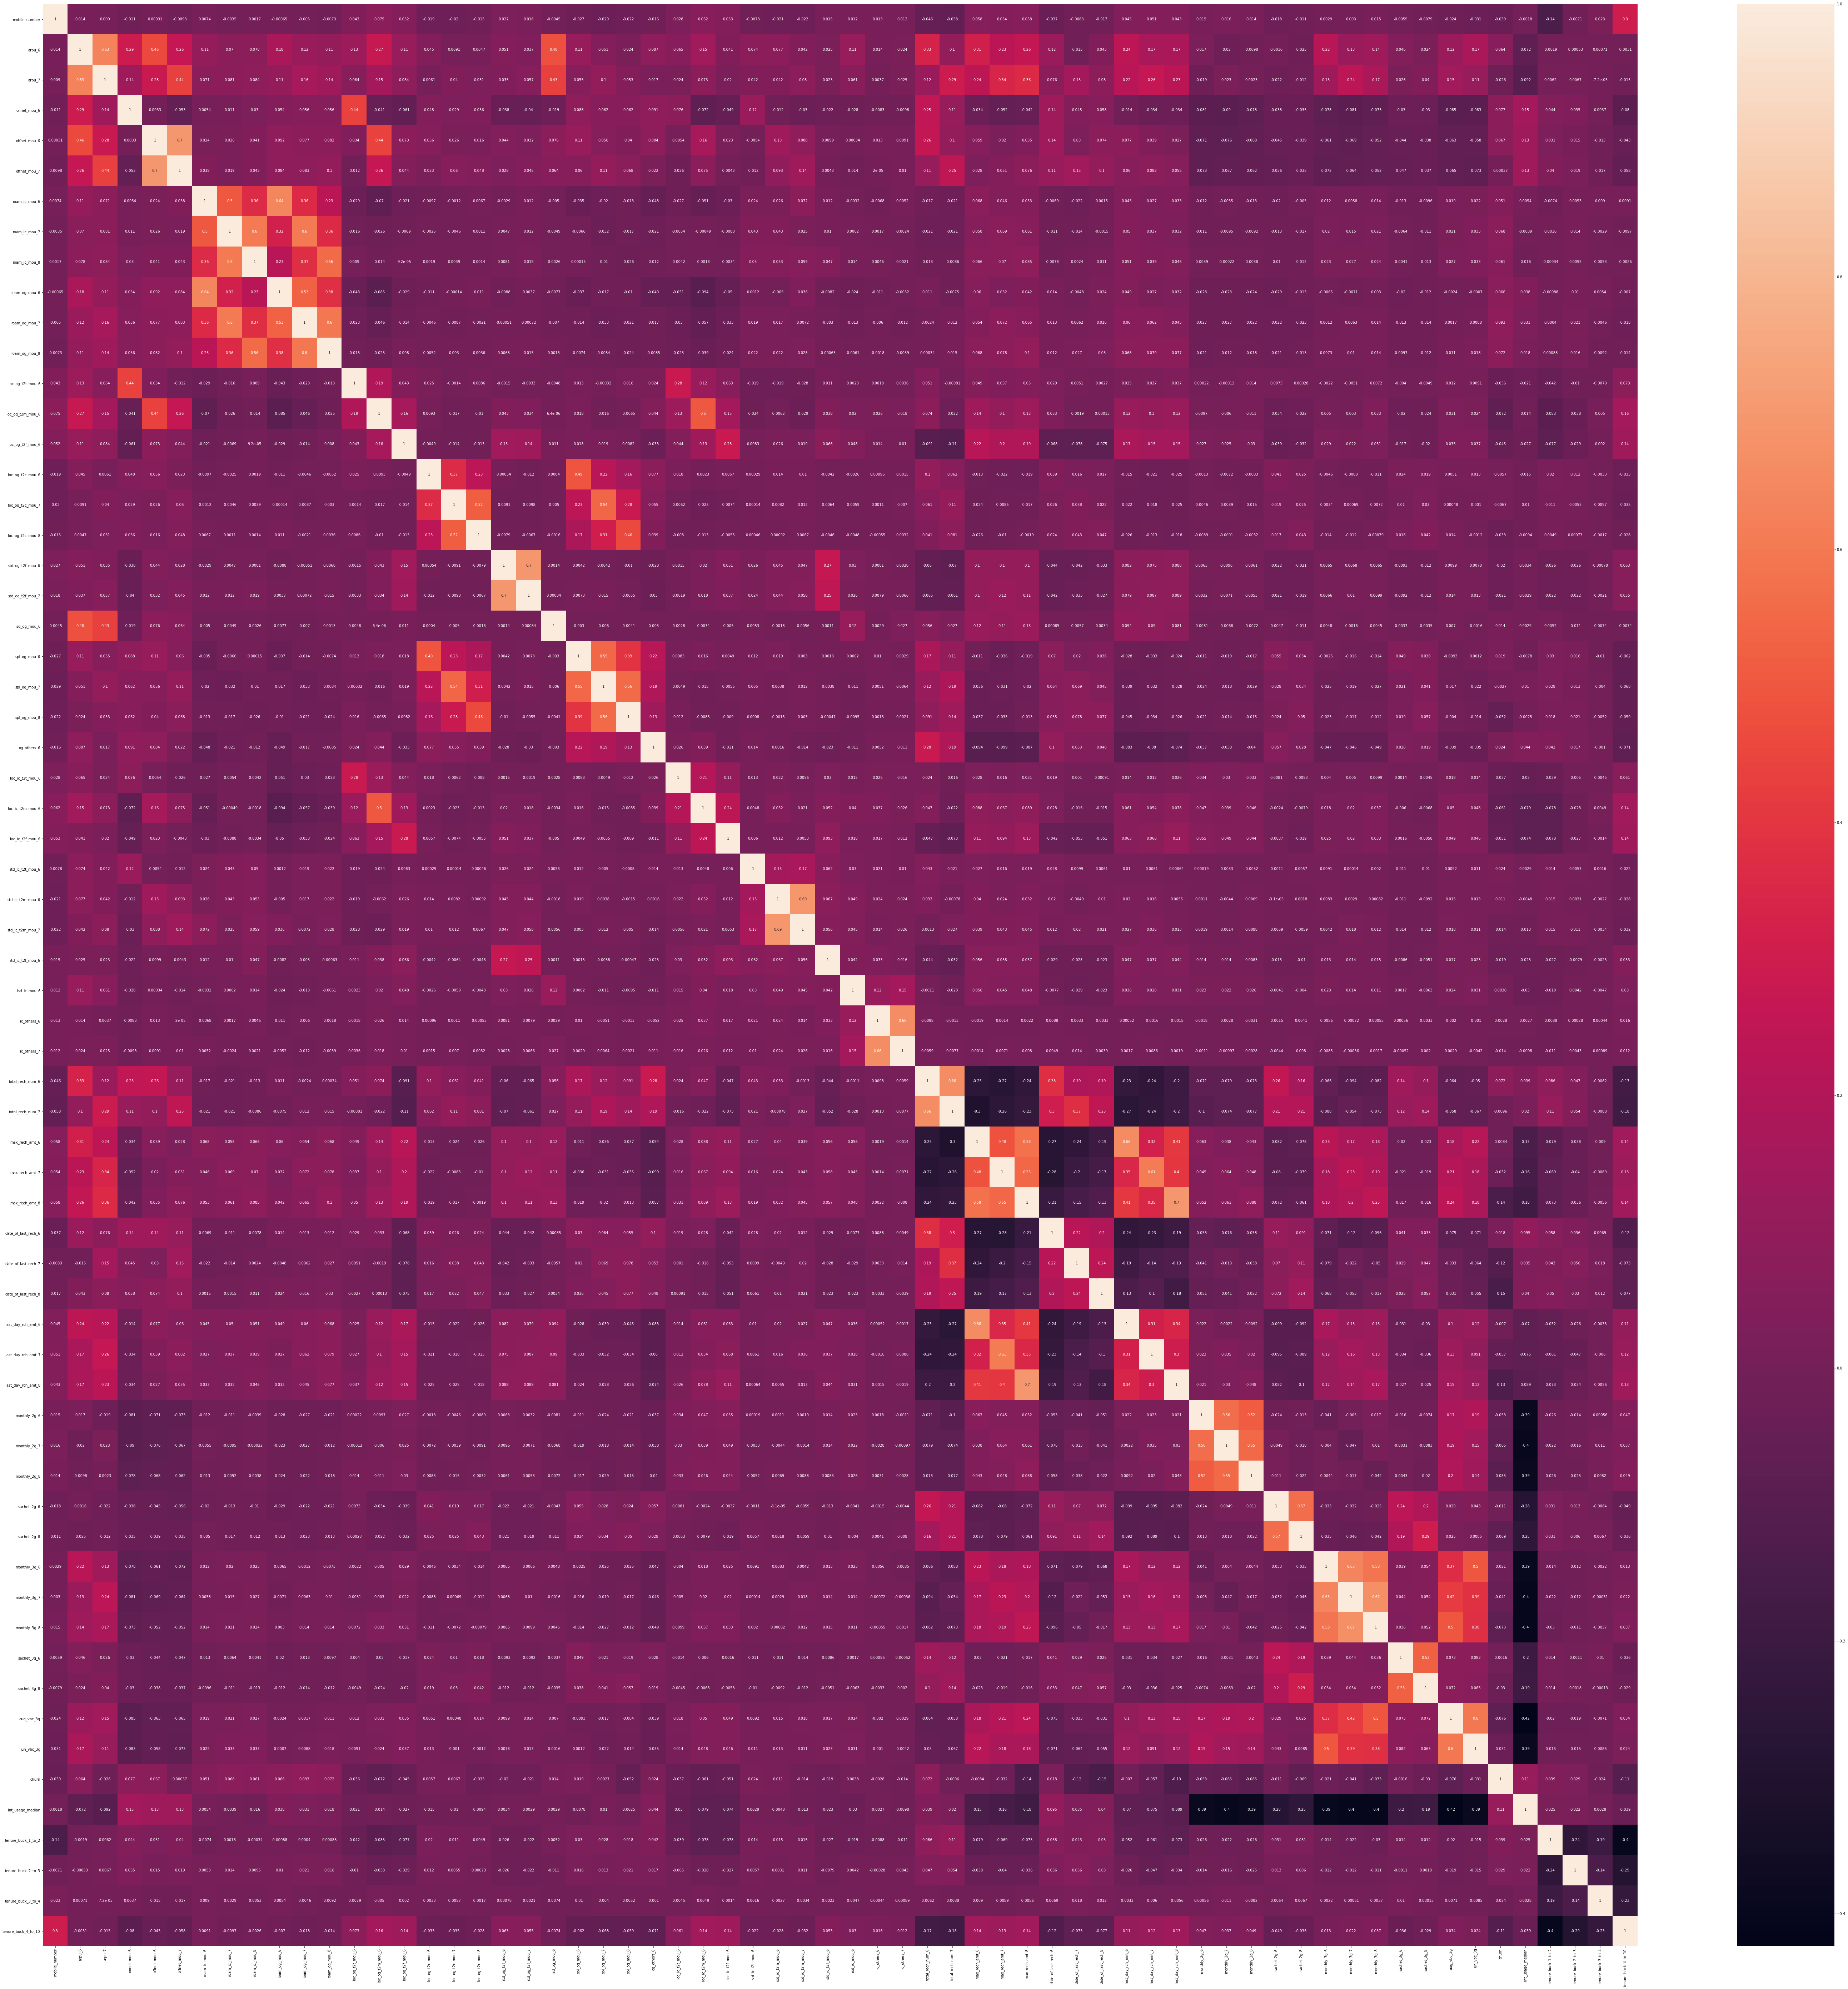

In [31]:
#Let's see the correlation matrix 
plt.figure(figsize = (100,100))        # Size of the figure
sns.heatmap(telecom_df4.corr(),annot = True)

In [32]:
telecom_df5 = telecom_df4
telecom_df5.head()

,mobile_number,arpu_6,arpu_7,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,sachet_3g_6,sachet_3g_8,aug_vbc_3g,jun_vbc_3g,churn,int_usage_median,tenure_buck_1_to_2,tenure_buck_2_to_3,tenure_buck_3_to_4,tenure_buck_4_to_10
7,7000701601,1069.180,1349.850,57.84,453.43,567.16,16.23,33.49,31.64,23.74,...,0,0,57.74,18.74,1,1,0,1,0,0
8,7001524846,378.721,492.223,413.69,94.66,80.63,0.00,0.00,0.00,0.00,...,0,0,21.03,122.16,0,0,0,0,0,0
13,7002191713,492.846,205.671,501.76,413.31,119.28,23.53,144.24,72.11,7.98,...,0,0,0.00,0.00,0,1,0,0,0,1
16,7000875565,430.975,299.869,50.51,296.29,229.74,0.00,2.83,0.00,0.00,...,0,0,0.00,21.89,0,1,1,0,0,0
17,7000187447,690.008,18.980,1185.91,61.64,0.00,0.00,4.76,4.81,0.00,...,0,0,0.00,0.00,0,1,1,0,0,0


### Model Building
#### Splitting Data into Training and Test Sets

In [33]:
from sklearn.model_selection import train_test_split

# Putting feature variable to X
X = telecom_df5.drop(['churn','mobile_number'],axis=1)

# Putting response variable to y
y = telecom_df5['churn']

# defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                                                                          
# applying normalize ( ) to all columns 
X_norm = X.apply(normalize) 
X_norm.head()

,arpu_6,arpu_7,onnet_mou_6,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,...,monthly_3g_8,sachet_3g_6,sachet_3g_8,aug_vbc_3g,jun_vbc_3g,int_usage_median,tenure_buck_1_to_2,tenure_buck_2_to_3,tenure_buck_3_to_4,tenure_buck_4_to_10
7,0.110967,0.090525,0.007841,0.054223,0.058669,0.006211,0.008782,0.007588,0.006289,0.004477,...,0.0,0.0,0.0,0.004470,0.001678,1.0,0.0,1.0,0.0,0.0
8,0.087944,0.067446,0.056081,0.011320,0.008341,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.001628,0.010940,0.0,0.0,0.0,0.0,0.0
13,0.091750,0.059734,0.068019,0.049425,0.012339,0.009004,0.037826,0.017293,0.002114,0.012539,...,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0
16,0.089687,0.062269,0.006847,0.035431,0.023765,0.000000,0.000742,0.000000,0.000000,0.006309,...,0.0,0.0,0.0,0.000000,0.001960,1.0,1.0,0.0,0.0,0.0
17,0.098324,0.054710,0.160764,0.007371,0.000000,0.000000,0.001248,0.001154,0.000000,0.003008,...,0.0,0.0,0.0,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size=0.7,test_size=0.3,random_state=100)

## PCA
- We can add class_weight = 'balanced'
- Lets do PCA 

In [35]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [36]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

In [37]:

colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 
                       'PC3':pca.components_[2],'PC4':pca.components_[3],
                       'PC5':pca.components_[4],'PC6':pca.components_[5],
                       'PC7':pca.components_[6],'PC8':pca.components_[7],
                       'PC9':pca.components_[8],'PC10':pca.components_[9],
                       'Feature':colnames})
pcs_df.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Feature
0,0.000170,0.002248,0.000353,-0.000188,-0.004901,0.001753,-0.003802,-0.015044,-0.011000,0.101081,arpu_6
1,-0.000043,0.002572,0.000414,-0.000302,-0.009313,0.001874,-0.004871,0.005962,-0.011309,0.081216,arpu_7
2,-0.012815,-0.018191,0.001643,-0.000314,-0.029168,0.009853,-0.029797,-0.046063,-0.022462,-0.030512,onnet_mou_6
3,-0.006936,-0.015465,-0.000383,-0.003421,-0.028774,0.011963,-0.019309,-0.040822,-0.016501,0.510295,offnet_mou_6
4,-0.007614,-0.013576,-0.000458,-0.003099,-0.040462,0.014145,-0.023821,0.014070,-0.013116,0.407316,offnet_mou_7
5,0.000354,-0.000519,-0.000009,0.000279,0.002714,-0.002519,0.004246,-0.003579,-0.005222,0.021878,roam_ic_mou_6
6,-0.000216,0.000002,0.000606,-0.000177,0.002586,-0.000396,0.002159,-0.000266,-0.004055,0.020826,roam_ic_mou_7
7,0.000013,0.000642,0.000643,-0.000229,0.000370,-0.000292,0.001888,0.001121,-0.003776,0.022610,roam_ic_mou_8
8,-0.000814,-0.002670,0.000778,0.000033,-0.000778,-0.000608,0.003865,-0.006252,-0.005895,0.034154,roam_og_mou_6
9,-0.001292,-0.001922,0.001444,-0.000736,0.000339,0.000265,0.003078,-0.001543,-0.009356,0.052488,roam_og_mou_7


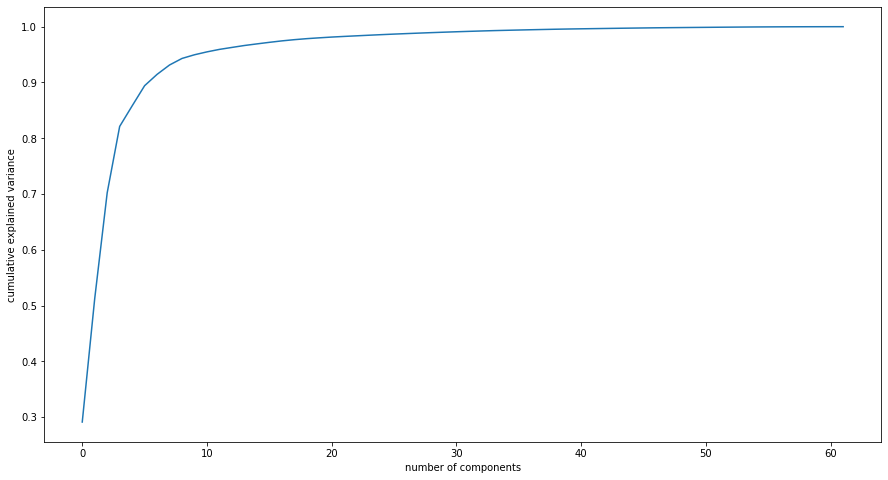

In [38]:
%matplotlib inline
fig = plt.figure(figsize = (15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### As we can see 40 component explain 90% of variance in the data

In [39]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=40)

df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(20985, 40)

### Correlation matrix

In [40]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())


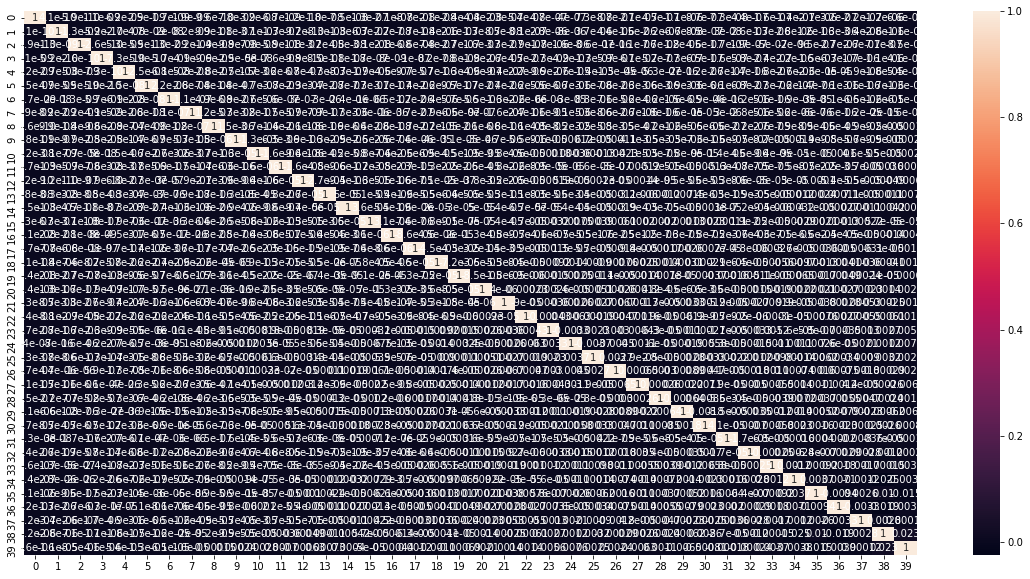

In [41]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)

In [42]:
#Applying selected components to the test data - 20 components
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8994, 40)

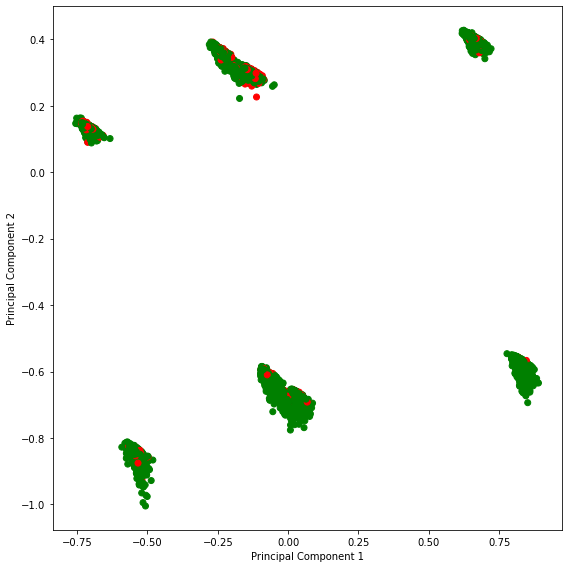

In [43]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(df_train_pca[:,0], df_train_pca[:,1], c = y_train.map({0:'green',1:'red'}))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

### LogisticRegression model with PCA
- Modeling with selected 40 pca feature 

In [44]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(df_train_pca,y_train)

C:\Users\91975\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- Making prediction on the test data

In [45]:

pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.83'

In [46]:
#Making prediction on the test data
pred_test = model_pca.predict_proba(df_test_pca)
y_pred_default = model_pca.predict(df_test_pca)

In [47]:
print(classification_report(y_test,y_pred_default))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      8179
           1       0.25      0.74      0.38       815

    accuracy                           0.78      8994
   macro avg       0.61      0.76      0.62      8994
weighted avg       0.90      0.78      0.82      8994



In [48]:
print(confusion_matrix(y_test,y_pred_default))

[[6399 1780]
 [ 214  601]]


In [49]:

print(accuracy_score(y_test,y_pred_default))

0.7782966422059151


In [50]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})


In [51]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC score: ',roc_auc)

ROC_AUC score:  0.8340430415466213


- Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0

In [52]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()

0    8179
1     815
Name: churn, dtype: int64

### Confusion matrix 

In [53]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

array([[6302, 1877],
       [ 204,  611]], dtype=int64)

### Logistic Regression model matrics with PCA -

In [54]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score on test data: ', accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

Accuracy Score on test data:  0.7782966422059151
Sensitivity:  0.7496932515337423
Specificity:  0.7705098422790072
false postive rate:  0.2294901577209928
positive predictive value:  0.24557877813504822
Negative predictive value:  0.968644328312327
Misclassification Rate:  0.23137647320435847


## LogistcRegression model with RFE
- As we have seen with PCA we select 40 component.
- We are selecting 10 feature from RFE

In [55]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced')
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 10)             # running RFE with 40 variables as output as PCA gave 40
rfe = rfe.fit(X_norm,y)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)           # Printing the ranking

C:\Users\91975\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\91975\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\91975\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of 

C:\Users\91975\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [ ]:
col = X_train.columns[rfe.support_]
col

In [ ]:
import statsmodels.api as sm
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### Correlation matrix

In [ ]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(X_norm[col].corr(),annot = True)

### VIF value

In [ ]:
col_for_vif = list(col)
col_for_vif.append('churn')
# telecom_df4.head()
vif_cal(input_data=telecom_df4[col_for_vif], dependent_col='churn')

In [ ]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression(class_weight='balanced')
logsk.fit(X_train[col], y_train)

In [ ]:

#Making prediction on the test data
pred_test = logsk.predict_proba(X_test[col])
y_pred_default = logsk.predict(X_test[col])

In [ ]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score : ',accuracy_score(y_test,y_pred_default))

In [ ]:

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(pred_test)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'churn_prob'})


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds =roc_curve(y_pred_final.churn,y_pred_final.churn_prob)
roc_auc = auc(fpr, tpr)
print('ROC_AUC Score: ',roc_auc)

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.churn_prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()


In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    sensi = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    speci = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

In [ ]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])

In [ ]:
# Creating new column 'predicted' with 1 if Churn_Prob>0.49 else 0
y_pred_final['pred_churn'] = y_pred_final.churn_prob.map( lambda x: 1 if x > 0.49 else 0)

y_pred_final.churn.value_counts()


In [ ]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.churn, y_pred_final.pred_churn )
confusion

In [ ]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print('Accuracy Score : ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

#### As we can see Above LogisticRegression giving good Accuracy with PCA and with RFE

### With PCA
- Accuracy Score on test data:  0.8152101400933957
- Sensitivity:  0.7987730061349694
- Specificity:  0.8073114072625015
- false postive rate:  0.19268859273749847
- positive predictive value:  0.29232150875617424
- Negative predictive value:  0.9757647406531698
- Misclassification Rate:  0.1934623082054703


### With RFE
- Accuracy Score :  0.8102068045363575
- Sensitivity:  0.8134969325153374
- Specificity:  0.8035212128622081
- false postive rate:  0.1964787871377919
- positive predictive value:  0.2920704845814978
- Negative predictive value:  0.9773944080904223


## RandomForestClassifier with PCA

In [ ]:
# Random forest

# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

# fit
rfc.fit(df_train_pca,y_train)

# Making predictions
y_pred_default = rfc.predict(df_test_pca)

In [ ]:
confusion_rf=confusion_matrix(y_test,y_pred_default)
confusion_rf

In [ ]:
TN = confusion_rf[0,0] # true positive 
TP = confusion_rf[1,1] # true negatives
FP = confusion_rf[0,1] # false positives
FN = confusion_rf[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

### Hyperparameter tuning for RandomForest

In [ ]:
#Lets do some hyper parameter tuning 
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5
# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf_with_pca = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf_with_pca = GridSearchCV(rf_with_pca, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1)
rf_with_pca.fit(df_train_pca, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf_with_pca.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# Tuning n_estimators
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf.fit(df_train_pca, y_train)

In [ ]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10,class_weight='balanced')


# fit tree on training data
rf.fit(df_train_pca, y_train)

In [ ]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf.fit(df_train_pca, y_train)

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf.fit(df_train_pca, y_train)

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8,10],
    'min_samples_leaf': range(100, 200, 100),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': range(200, 400, 100), 
    'max_features': [8, 10, 12]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 5, n_jobs=-1, verbose = 1)

In [ ]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=8,
                             n_estimators=300)

In [ ]:
# fit
rfc.fit(df_train_pca,y_train)

In [ ]:
# predict
y_pred_default = rfc.predict(df_test_pca)

In [ ]:
print(classification_report(y_test,y_pred_default))
print(confusion_matrix(y_test,y_pred_default))
print('accuracy_score:  ',accuracy_score(y_test,y_pred_default))

In [ ]:
# Confusion Matrix
confusion_rf_hyper=confusion_matrix(y_test,y_pred_default)
confusion_rf_hyper

In [ ]:
TN = confusion_rf_hyper[0,0] # true positive 
TP = confusion_rf_hyper[1,1] # true negatives
FP = confusion_rf_hyper[0,1] # false positives
FN = confusion_rf_hyper[1,0] # false negatives

print('Accuracy Score:  ',accuracy_score(y_test,y_pred_default))

# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

## RandomForest on all feature

In [ ]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier(class_weight='balanced')

In [ ]:
# fit
rfc.fit(X_train,y_train)

In [ ]:
# Making predictions
predictions = rfc.predict(X_test)

In [ ]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

In [ ]:
# Confusion Matrix
confusion_rf_with_all_feature=confusion_matrix(y_test,predictions)
confusion_rf_with_all_feature

In [ ]:
TN = confusion_rf_with_all_feature[0,0] # true positive 
TP = confusion_rf_with_all_feature[1,1] # true negatives
FP = confusion_rf_with_all_feature[0,1] # false positives
FN = confusion_rf_with_all_feature[1,0] # false negatives

print('Accuracy Score: ', accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

## Hyperparameter Tuning 

In [ ]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1)


In [ ]:
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1000, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", n_jobs=-1)
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train, y_train)

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

In [ ]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf.fit(X_train, y_train)

In [ ]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 700, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf.fit(X_train, y_train)

In [ ]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10,12],
    'min_samples_leaf': range(150, 250, 50),
    'min_samples_split': range(200, 400, 100),
    'n_estimators': [300,400,500], 
    'max_features': [15, 20]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 3, verbose = 1, n_jobs=-1)

In [ ]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc_final = RandomForestClassifier(bootstrap=True,class_weight='balanced',
                             max_depth=10,
                             min_samples_leaf=150, 
                             min_samples_split=300,
                             max_features=15,
                             n_estimators=500)

In [ ]:
# fit
rfc_final.fit(X_train,y_train)

In [ ]:
# predict
predictions = rfc_final.predict(X_test)

In [ ]:
from sklearn import metrics
confusion_rm_f = metrics.confusion_matrix( y_test, predictions )
confusion_rm_f

In [ ]:
TN = confusion_rm_f[0,0] # true positive 
TP = confusion_rm_f[1,1] # true negatives
FP = confusion_rm_f[0,1] # false positives
FN = confusion_rm_f[1,0] # false negatives

print('Accuracy Score: ',accuracy_score(y_test,predictions))
# Let's see the sensitivity of our logistic regression model
print('Sensitivity: ', TP / float(TP+FN))

# Let us calculate specificity
print('Specificity: ',TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print('false postive rate: ',FP/ float(TN+FP))

# positive predictive value 
print('positive predictive value: ', TP / float(TP+FP))

# Negative predictive value
print('Negative predictive value: ',TN / float(TN+ FN))

## Misclassification rate

print('Misclassification Rate: ',(FN+FP)/(TP+TN+FP+FN))

### RandomForest model with All feature gives: 
- **85.22%** of Accuracy and **85.03%** of Sensitivity

In [ ]:
#Important Variables
from collections import OrderedDict
feature_names=list(X_train.columns.values)
important_features_dict = {}
for name, importance in zip(feature_names, rfc_final.feature_importances_):
    important_features_dict[name]=importance
#Sorting Dictionary in descending order of the importance variable
d_descending = OrderedDict(sorted(important_features_dict.items(), 
                                  key=lambda kv: kv[1], reverse=True))

In [ ]:
telecom_df5.columns

In [ ]:
#Variable Importance top 30 variable
dic= dict(d_descending)

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n=12
n_items = take(n, dic.items())

In [ ]:
print('These are top 12 driver variable: ',n_items)

In [ ]:
imp=rfc_final.feature_importances_
names=X_train.columns.values
imp,names=zip(*sorted(zip(imp,names)))

df_1=pd.DataFrame({"Variable":names,"importance":imp})
df_2 = df_1.sort_values(by="importance",axis=0,ascending=False)
df_2 = df_2.reset_index(drop=True)


plt.figure(figsize=(20, 10))

ax = sns.barplot(x='Variable', y= 'importance', data=df_2[0:12])
ax.set(xlabel = 'Top 12 Features', ylabel = 'Importance')
plt.show()

In [ ]:
telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['arpu_6', 'arpu_7', 'arpu_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Arpu across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('Average Incoming Call for August - Roaming trend across months', fontsize=20)
plt.show()

df_sample = telecom_df2.groupby(['churn'])['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8'].mean()
df_sample.plot.bar()
plt.suptitle('Maximum Recharge Amount', fontsize=20)
plt.show()


df_sample = telecom_df2.groupby(['churn'])['spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8'].median()
df_sample.plot.bar()
plt.suptitle('Special Outgoing Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average Special Outgoing Call")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('STD income Call trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average STD income Call volume")
plt.show()


df_sample = telecom_df2.groupby(['churn'])['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC out going trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC out going")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8'].mean()
df_sample.plot.bar()
plt.suptitle('LOC in coming trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average LOC in coming")
plt.show()

df_sample = telecom_df2.groupby(['churn'])['ic_others_6', 'ic_others_7', 'ic_others_8'].mean()
df_sample.plot.bar()
plt.suptitle('In coming call to Other trend across months', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Average In coming call to Other")
plt.show()

telecom_df2['churn'] = telecom_df2['churn'].astype('object', copy = False)
df_sample = telecom_df2.groupby(['churn'])['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'].median()
df_sample.plot.bar()
plt.suptitle('Distribution of Last Day Recharge Amount', fontsize=20)
plt.xlabel("Churn")
plt.ylabel("Median Last Day Recharge Amount")
plt.show()

### Driver Variables of Churn and Churn Analysis & Recommendation

- Average Revenue Per User decreases from 6th to 8th month as most of the users are churned by 8th month.
- Maximum Recharge amount reduces for those who are prone to churning
- Lower the last day recharge amount higher the churn rate. Focus on customers whos last day recharge amount has decrased. Specialy for customers without any recharge amount.
- Higher the incoming roaming amount, higher is the churn rate. Focus on customers whose incoming roaming amount has increased, because they are likely to churn.
- Lower the STD incoming call, higher is the churn rate. Focus on customers whose STD incoming call amount has decreased for that month.
- Avg max recharge amount has been decreases for those who are prone to churning.